# Travel Salesman Problem Qatar

The Travel Salesman Problem is a known problem in combinatorial optimization. The goal is to determine the shortest path through differents locations. Here the goal is to find the shortest path to visit each and every cities of Qatar and return to the start.
The computational complexity increases very quickly as the complexity is factorial. Exemple for 6 cities the number of combinations is **6!= 720 posssibilities**
for 12 cities it becomes **12!=479001600 possibilities!**
This problem has many applications (logistic, astronomy etc) and is still an active scope of research

In [1]:
#Import librairies
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import time
import math
import matplotlib.pyplot as plt
import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt
import tsplib95

In [2]:
#Open the tsp file with tsplib95
with open('C:/Users/Fouad/Desktop/DSTI courses/Metaheuristics/Qatar.tsp') as f:
    problem = tsplib95.read(f)

In [3]:
#Define a class City with x,y coordinates and a distance method to compute distances between 2 cities
Cities_list = []
class City:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        Cities_list.append(self)
        
    def distance(self, city):
        xDis = abs(self.x - city.x)
        yDis = abs(self.y - city.y)
        distance = np.sqrt((xDis ** 2) + (yDis ** 2))
        return distance
    
    def __repr__(self):
        return "(" + str(self.x) + "," + str(self.y) + ")"  

In [4]:
#Create a class fitness to define the route
class Fitness:
    def __init__(self, route):
        self.route = route
        self.distance = 0
        self.fitness= 0.0
    
    def routeDistance(self):
        if self.distance ==0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if i + 1 < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        if self.fitness == 0:
            self.fitness = 1 / float(self.routeDistance())
        return self.fitness

In [5]:
#Initial route is random from list of cities
def createRoute(cityList):
    route = random.sample(cityList, len(cityList))
    return route

In [6]:
#We have created 1 inidividual, to create a population we add a parameter popSize
def initialPopulation(popSize, cityList):
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

In [7]:
#Determine fitness each inidividual will be ranked thanks to the distance (routeFitness method of the Fitness class)
def rankRoutes(population):
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [8]:
#We select the best individuals to produce the next generations we keep finally the route IDs of our selection
def selection(popRanked, eliteSize):
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

In [9]:
def matingPool(population, selectionResults):
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

In [10]:
#Creation of the next generations with crossover or "breeding" 
def breed(parent1, parent2):
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
    #A city cannot appear twice in a route     
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

In [11]:
#Creation of the offspring population, thanks to elitesize we keep the best route of the population
def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [12]:
#To avoid local convergence we use a function called "mutate" this is first applied to 1 individual
def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [13]:
#The mutate function is then extend to the whole population
def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [14]:
#Finally we produce differents generations
def nextGeneration(currentGen, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [15]:
#FInally apply the genetic algorithm and see from how much we improved the global distance
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    global pop
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    print(f"best route index is" +str(bestRouteIndex))
    bestRoute = pop[bestRouteIndex]
    return bestRoute

In [16]:
#Extract coordinates of the dictionnary from the problem file
coords_dict = problem.node_coords
coords = [*coords_dict.values()]

In [17]:
#Extract in 2 separates lists x and y coordinates
coords_x = [i[0] for i in coords]
coords_y = [i[1] for i in coords]

In [18]:
#Instanciate an object of the City class
cityList = []
for i in range(194):
    cityList.append(City(x=int(coords_x[i]), y=int(coords_y[i])))

In [19]:
# Use the genetic algorithm to minimize the distance path between the cities
start_time = time.time()
best_route_gen=geneticAlgorithm(population=cityList, popSize=200, eliteSize=45, mutationRate=0.0001, generations=1000)
print("--- %s seconds ---" % (time.time() - start_time))

Initial distance: 82778.60525102512
Final distance: 23730.559418271867
best route index is0
--- 234.54004406929016 seconds ---


We put the coordinates of the best route inside the **"best_route_gen"** variable

In [20]:
print(f"These are the shortest path found cities coordinates :{best_route_gen}")

These are the shortest path found cities coordinates :[(25313,50883), (25316,50766), (25419,50793), (25500,50980), (25451,50925), (25480,50938), (25533,50977), (25567,50958), (25404,51073), (25400,51183), (25363,51281), (25337,51425), (25291,51424), (25300,51394), (25292,51520), (25341,51507), (25574,51486), (25734,51547), (25683,51505), (25650,51372), (25483,51383), (25490,51373), (25469,51397), (25478,51362), (25538,51408), (25545,51387), (25550,51433), (25566,51484), (25610,51475), (25622,51454), (25700,51584), (25708,51591), (25440,51378), (25459,51316), (25531,51304), (25510,51242), (25560,51158), (25495,50965), (25444,50958), (25429,50785), (25495,50846), (25765,51019), (25751,50920), (25826,51043), (25957,51075), (26099,51161), (26077,51222), (25951,51349), (25871,51354), (25983,51328), (26133,51300), (25937,51313), (26078,51361), (26123,51222), (26033,51166), (26033,51163), (26083,51147), (26008,51083), (26150,51108), (26074,51083), (26133,51216), (25966,51283), (26050,51297), 

In [21]:
def geneticAlgoFitnessPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Fitness (distance)')
    plt.xlabel('Generation')
    plt.show()

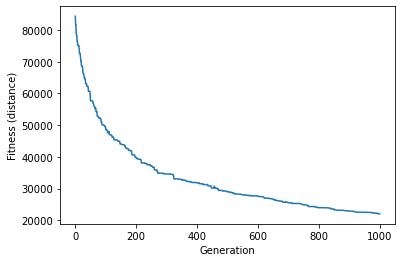

In [27]:
#Plot the fitness function against the number of generation
geneticAlgoFitnessPlot(population=cityList, popSize=200, eliteSize=45, mutationRate=0.0001, generations=1000)

The optimal tour for Qatar has a length of 9352. The result we got is quite good (less than 4 minutes).
The number of possibilities for this problem is factorial 194 which is really a huge number. We confirmed genetic algorithm is a good way to get a good solution in a short amount of time for the Traveller
Salesman Problem !

In [28]:
#Transform best_route_gen into lists of lists (initially list of tuples which are imutable)
def get_list_of_list():
    best_route_gen_arr = np.array(best_route_gen)
    a = []
    b = []
    for l in best_route_gen_arr:
        a.append(l.x)
        b.append(l.y)
    a = np.array(a)
    b = np.array(b)

    a = a.reshape(-1,1)
    b = b.reshape(-1,1)
    best_route_gen_list = np.concatenate((a,b),axis=1)
    return best_route_gen_list

In [29]:
# Get best_route_gen as list of lists
best_route_gen_list = get_list_of_list()

In [35]:
#Create dataframe with x, y coordinate to merge them with the best_route_coord
def get_cities_from_coor(coords_dict,best_route_gen_list):
    df = pd.DataFrame.from_dict(coords_dict, orient='index',columns=['x', 'y'])

    trunc = lambda x: int(x)

    df['xc']=df['x'].apply(trunc)
    df['yc']=df['y'].apply(trunc)
    df['city'] = [i+1 for i in range(194)]

    #To extract the cities index of the best_route
    df_br = pd.DataFrame(best_route_gen_list[:,0],columns=['xc'])
    df_br['yc'] = best_route_gen_list[:,1]
    df_br['rank'] = [i+1 for i in range(194)]
    result = pd.merge(df, df_br, how='left', on=['xc', 'yc'])
    result.sort_values(by=['rank'])
    #Extract cities index
    best_route_gen_list_ord = result['rank'].values
    return best_route_gen_list_ord

In [36]:
best_route_gen_list_ord = get_cities_from_coor(coords_dict,best_route_gen_list)
print(f"Best route is the following path :{best_route_gen_list_ord}")

Best route is the following path :[187 180 183 181 186 131 182 188 178 184 137 179 189 130 158 190 132 185
 169 194 148 149 136 138 135 133 157 151 152 163 164 172 150 177 173 193
 118 119 170 175 161 154 153 165 147 174 155 176 171 146 144 156 129 160
 166 159  13  15 191  14 145 192   1 124   2 168 167 162 142  12 134 140
  16 125  11 139 122 126 120  10 123   9 121 143   3  40 141  33  39   5
  34  23  24   6  21  22 127  41  38 128   4  36  35   7  25  26 117  27
  37  28   8  17 104 103  29  30 116  20  69  19  71  79  31  32  68 102
  67  18  70  43  72  42 115  98  76  73 101  95  65  44 109  88  80  96
 100  97 105  77  87  85  49 108 106  75  74  66  86  84  52  81  64  48
  45  89  62  82  50  78  58 110 114  92  55  56  93  94 107  63  99  83
 111  60 113  47  53  57  46  90 112  91  54  61  51  59]


In [40]:
def plot_tsp():
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(122)
    for first,second in zip(best_route_gen[:-1],best_route_gen[1:]):
        ax.plot([first.x,second.x],[first.y,second.y],'b')
    ax.plot([best_route_gen[0].x,best_route_gen[-1].x],[best_route_gen[0].y,best_route_gen[-1].y],'b')
    ax.set_xlabel('x coordinates')
    ax.set_ylabel('y coordinates')
    ax.set_title('TSP solution proposal for Qatar (194 cities) using genetic algorithm 23730 km (optimum = 9352km)',fontsize=16)
    for c in best_route_gen:
        ax.plot(c.x,c.y,'ro')

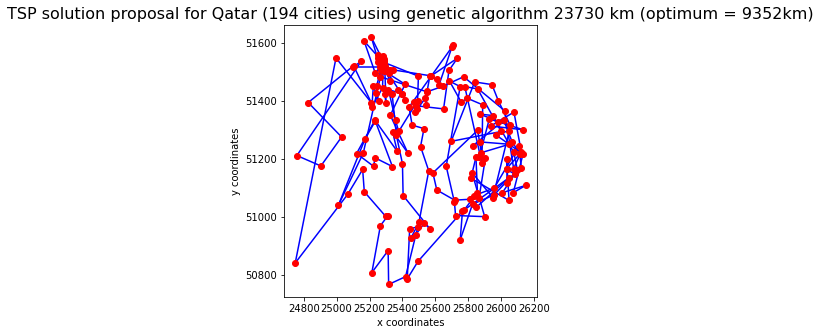

In [41]:
plot_tsp()